<a href="https://colab.research.google.com/github/mjmousavi97/Deep-Learning-Tehran-uni/blob/main/HomeWorks/02%20HW/advanced_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
import torch  # Core PyTorch library for tensors and GPU computations
from torch import nn  # Module for building neural network layers
import torch.nn.functional as F  # Functional API for layers and activations (stateless functions)
from torch.utils.data import DataLoader, Dataset  # Tools for batching, shuffling, and creating custom datasets

import torchvision  # PyTorch package for computer vision datasets, models, and transforms
from torchvision import transforms  # Image preprocessing and transformations (resize, normalize, etc.)
from torchvision.datasets import ImageFolder  # Loads images from folders organized by class labels

import matplotlib.pyplot as plt  # Plotting graphs and displaying images
import numpy as np  # Numerical computations and array operations
import seaborn as sns  # Statistical data visualization
import os  # File and directory operations
import glob  # File path pattern matching (wildcards)
import cv2  # OpenCV for image processing (reading, editing, filtering, etc.)
from tqdm import tqdm  # Progress bar for loops
from PIL import Image  # Pillow library for opening, saving, and manipulating images


#### Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [3]:
DIR_TRAIN = "/content/drive/MyDrive/fashionmnist/train/"
DIR_TEST = "/content/drive/MyDrive/fashionmnist/test/"

In [4]:
classes = os.listdir(DIR_TRAIN)
print(f"Names of classes are: {classes}.\nThere are {len(classes)} classes.")

Names of classes are: ['Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser', 'Angle boot', 'Bag', 'Coat'].
There are 10 classes.


In [5]:
train_images = []
test_images = []

for _class in classes:
    train_images += glob.glob(DIR_TRAIN + _class + '/*.jpg')
    test_images += glob.glob(DIR_TEST + _class + '/*.jpg')

print("Total train images:", len(train_images))
print("Total test images:", len(test_images))

Total train images: 60000
Total test images: 10000


In [6]:
Transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(mean=0.5, std=0.5)])

In [7]:
train_dataset = torchvision.datasets.FashionMNIST(
    root = "data", # where to download data to
    train = True, # get training data
    download = True, # download data if it doesn't exist on disk
    transform = Transforms # images come as PIL format, we want to apply transform on them
)

test_dataset = torchvision.datasets.FashionMNIST(
    root = "data",
    train = False, # get test data
    download = True,
    transform = Transforms
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.09MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.54MB/s]


## Creating Dataloader

In [8]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    num_workers=2,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    num_workers=2
)

In [9]:
train_sample_batch, train_label_batch = next(iter(train_loader))

In [10]:
print(train_sample_batch.shape, '\n')
print(train_label_batch.shape)

torch.Size([32, 1, 28, 28]) 

torch.Size([32])


Text(0.5, 1.0, 'A sample image of train data with label=T-shirt')

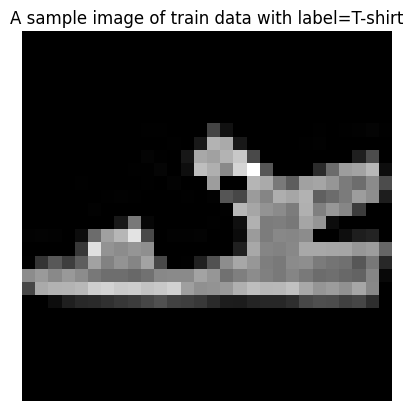

In [11]:
sample_image = train_sample_batch[0].permute(1, 2, 0)
label_of_sample_image = train_label_batch[0]

mean, std = 0.5, 0.5
sample_image = std * (sample_image + mean)

plt.imshow(sample_image, cmap='grey')
plt.axis('off')
plt.title(f'A sample image of train data with label={classes[label_of_sample_image]}')



# Network Structure




[CNN Explainer](https://poloclub.github.io/cnn-explainer/)



In [12]:
class CNN_Model(nn.Module):
    """
    A simple Convolutional Neural Network (CNN) model for image classification.

    Architecture:
    - Two convolutional layers each followed by Batch Normalization and ReLU activation.
    - A MaxPooling layer to downsample the feature maps.
    - A classifier consisting of Flatten, Dropout, and a Linear (fully connected) layer
      to produce the final output.

    Args:
        input_channel (int): Number of input channels (e.g., 3 for RGB images).
        hidden_unit (int): Number of filters (feature maps) in the convolutional layers.
        output_shape (int): Number of classes or output features.

    Forward pass:
        - Input tensor of shape (batch_size, input_channel, height, width).
        - Outputs raw logits of shape (batch_size, output_shape).
    """

    def __init__(self, input_channel, hidden_unit, output_shape):
        super().__init__()

        # Feature extractor: convolutional block
        self.CNN_block = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=input_channel, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=hidden_unit),  # Normalize activations for stability and faster convergence
            nn.ReLU(inplace=True),                      # Non-linear activation

            # Second convolutional layer
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=hidden_unit),  # Batch normalization again
            nn.ReLU(inplace=True),

            # MaxPooling to reduce spatial dimensions by factor of 2
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Classifier: fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),       # Flatten feature maps into a vector
            nn.Dropout(p=0.5),  # Dropout for regularization to prevent overfitting
            nn.Linear(in_features=hidden_unit*14*14, out_features=output_shape)  # Final linear layer for classification
        )

    def forward(self, x: torch.Tensor):
        """
        Defines the forward computation of the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_channel, height, width).

        Returns:
            torch.Tensor: Output logits of shape (batch_size, output_shape).
        """
        x = self.CNN_block(x)    # Pass input through convolutional feature extractor
        x = self.classifier(x)   # Pass extracted features through classifier
        return x


In [13]:
model = CNN_Model(input_channel=1, hidden_unit=10, output_shape=len(classes))
model

CNN_Model(
  (CNN_block): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=1960, out_features=10, bias=True)
  )
)

In [14]:
random_sample = torch.randn((1, 1, 28, 28))
model(random_sample).shape

torch.Size([1, 10])

# Training

# Understanding `with` and `tqdm` in Python

## `with` statement
- Used to wrap the execution of a block with methods defined by a context manager (`__enter__` and `__exit__`).
- Ensures proper setup and cleanup (e.g., opening and closing files, managing resources).
- Guarantees cleanup even if errors occur inside the block.
- Syntax example:
  ```python
  with open("file.txt", "r") as f:
      data = f.read()
  ```

## `tqdm`
- A Python library to display progress bars for iterables.
- Wraps any iterable (e.g., lists, ranges, DataLoader) to show progress.
- Updates progress bar each iteration, showing completion %, elapsed time, estimated time, etc.
- Common usage:
  ```python
  from tqdm import tqdm

  for item in tqdm(iterable, desc="Processing"):
      # process item
      pass
  ```
- Can be used with `with` to automatically handle progress bar lifecycle:
  ```python
  with tqdm(iterable, desc="Processing") as pbar:
      for item in pbar:
          # process item
          pass
  ```
- When wrapping a DataLoader, tqdm tracks progress over **all batches**, not individual samples.


In [15]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
    """
    Performs one full training epoch over the provided data loader.

    Args:
        model (torch.nn.Module): The neural network model to train.
        data_loader (DataLoader): DataLoader providing training batches.
        loss_fn (callable): Loss function to compute the error.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        accuracy_fn (callable): Function to calculate accuracy.
        device (torch.device): Device to run computations on (CPU or GPU).

    Returns:
        tuple: (average_train_loss, average_train_accuracy) over the epoch.
    """
    model.to(device)  # Move model to the specified device (CPU or GPU)
    train_loss, train_acc, counter = 0, 0, 0

    with tqdm(data_loader, desc='  train') as train_tqdm:
        for X, y in train_tqdm:
            # Move data to the specified device
            X, y = X.to(device), y.to(device)

            # Forward pass: predict outputs
            y_pred = model(X)

            # Compute the loss for current batch
            loss = loss_fn(y_pred, y)

            # Accumulate loss and accuracy values
            train_loss += loss.item()  # Convert tensor loss to float before accumulating
            train_acc += accuracy_fn(true=y.cpu(), pred=y_pred.cpu())

            counter += 1  # Increment batch counter

            # Update tqdm progress bar postfix with current average accuracy and loss
            train_tqdm.set_postfix(
                train_acc=train_acc / counter,
                train_loss=train_loss / counter,
                refresh=True
            )

            # Zero gradients before backward pass
            optimizer.zero_grad()

            # Backward pass: compute gradients
            loss.backward()

            # Update model parameters
            optimizer.step()

        # Compute average loss and accuracy over all batches
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)

    return train_loss, train_acc
